In [10]:
import os
from dotenv import load_dotenv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#setting up envirionment
load_dotenv()

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
#unseen
test_images_dir = os.path.join(project_root, os.getenv("TEST_IMAGES_DIR"))
#training and validation images  
class_images_dir = os.path.join(project_root, os.getenv("CLASS_TRAIN_IMAGES_DIR"))
#models
models_dir = os.path.join(project_root, os.getenv("MODEL_DIR"))
print(models_dir)

/Users/jubacochran/Downloads/cnn_binary/models


In [4]:
model_path = Path(models_dir)
binary_model_name = os.getenv("BINARY_MODEL")
print(model_path)
binary_model_path = model_path / binary_model_name
print(binary_model_path)

/Users/jubacochran/Downloads/cnn_binary/models
/Users/jubacochran/Downloads/cnn_binary/models/penguins_vs_turtles_model.h5


In [5]:
# Define image size and batch size

image_size = (224, 224)
model = load_model(binary_model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      6

In [ ]:
#Data Augmentation

tf.random.set_seed(42)


(1, 224, 224, 3)


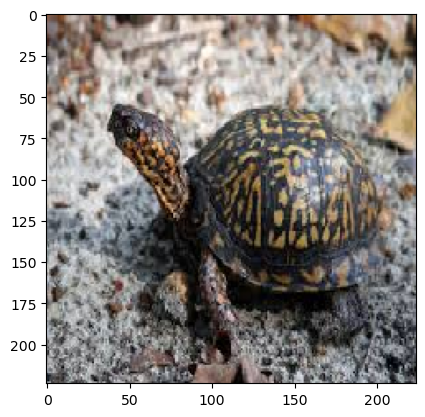

In [7]:
#Lets slow things down a bit and visualize a single image and explore feature maps
#CNNs are not black bloxes like their counterparts they are actually quite interpretable due to their representations of visual concepts
img_path = "/Users/jubacochran/Downloads/cnn_binary/dataset/val/image.png"
#preprocess image into a tensor
img = image.load_img(img_path, target_size=(224,224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255. #This is how the model was trained on input data

print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

1/1 [==============================] - 0s 48ms/step


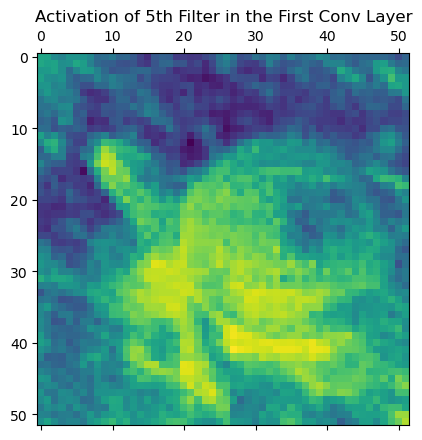

In [8]:
_ = model.predict(img_tensor) 

# Step 2: Explicitly create a new Input layer to ensure proper graph building
input_layer = keras.Input(shape=(224, 224, 3))  # Create a new Input layer
x = input_layer

# Step 3: Reconnect the first 8 layers manually to this new input
for layer in model.layers[:8]:
    x = layer(x)

# Create the new model using this manually connected input and output
activation_model = models.Model(inputs=input_layer, outputs=x)

# Step 4: Get the activations for the single image
activations = activation_model.predict(img_tensor)

# Step 5: Visualize the activations for the first layer
first_layer_activation = activations  # Since we're only looking at one layer

# Plot the activations of one of the filters in the first layer
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')
plt.title("Activation of 5th Filter in the First Conv Layer")
plt.show()




1/1 [==============================] - 0s 72ms/step


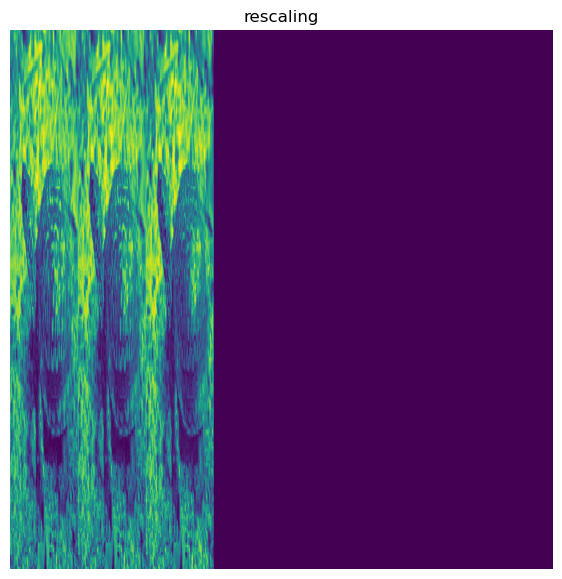

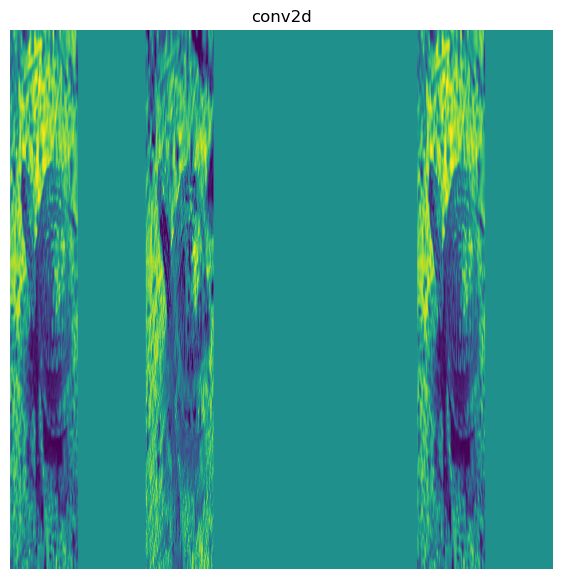

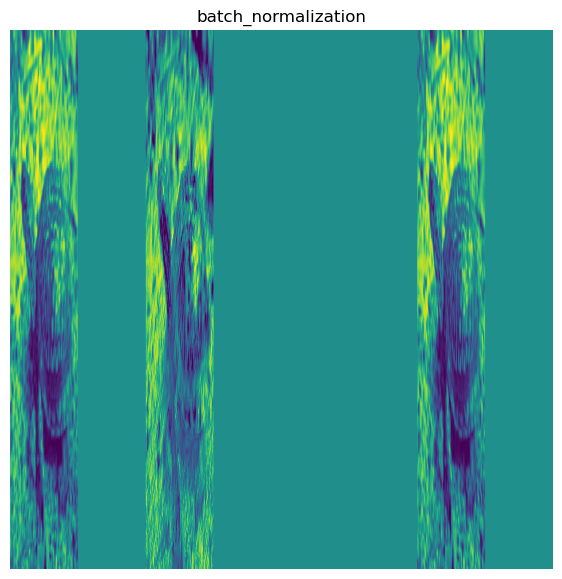

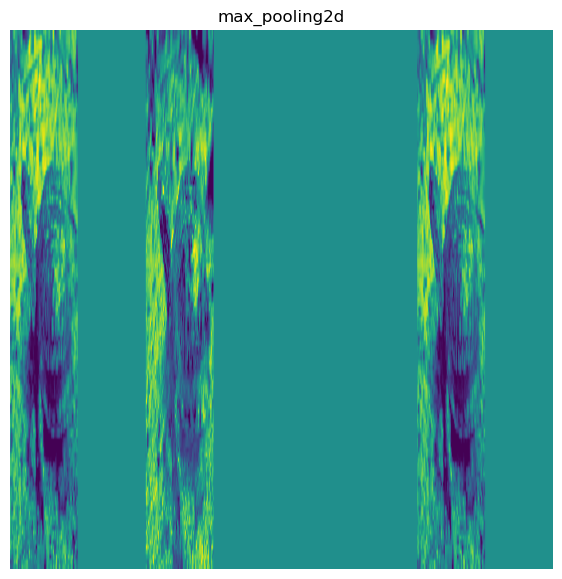

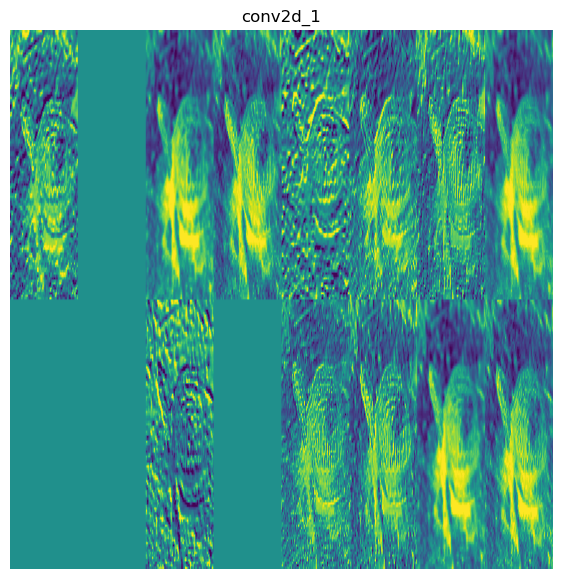

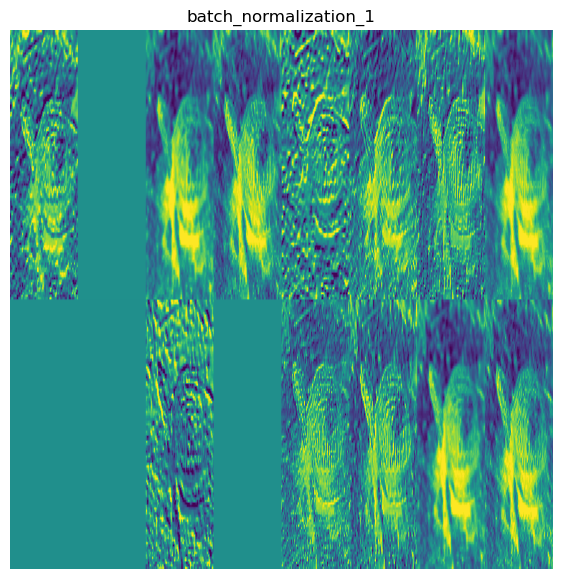

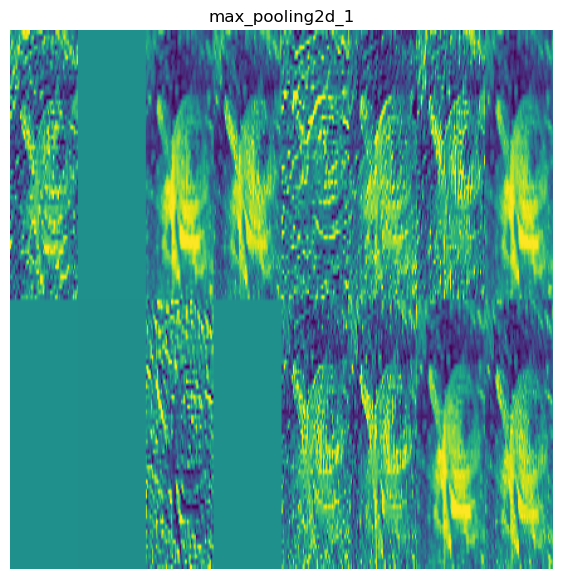

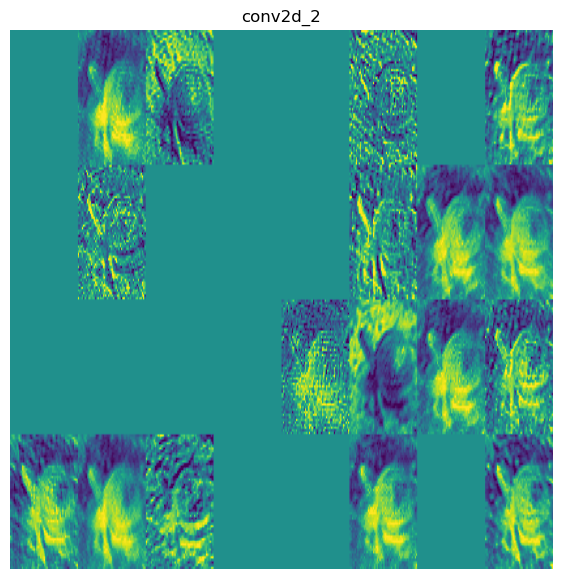

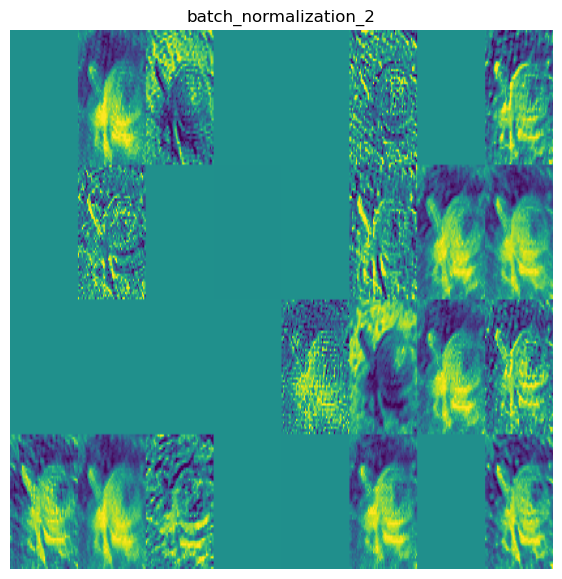

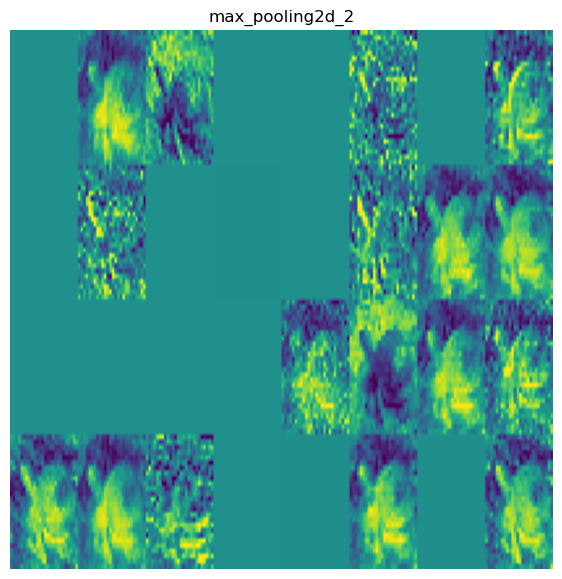

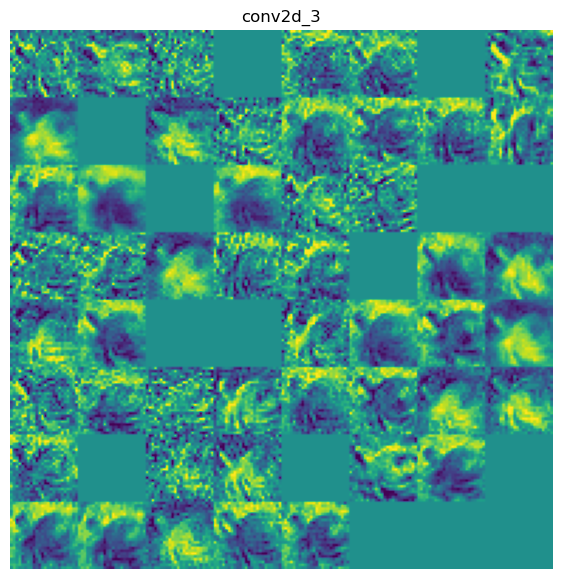

In [9]:
input_layer = keras.Input(shape=(224, 224, 3))
x = input_layer

# Reconnect all layers manually
layer_outputs = []
for layer in model.layers:
    x = layer(x)
    layer_outputs.append(x)

# Create the intermediate model
activation_model = models.Model(inputs=input_layer, outputs=layer_outputs)

# Get activations for each layer in the model
activations = activation_model.predict(img_tensor)

# Visualize convolutional layers only in a structured grid format
layer_names = [layer.name for layer in model.layers]

for layer_name, layer_activation in zip(layer_names, activations):
    if len(layer_activation.shape) == 4:  # Only visualize convolutional layers
        n_features = layer_activation.shape[-1]  # Number of feature maps (channels)
        size = layer_activation.shape[1]         # Height and width of feature map

        # Determine the number of rows and columns for the grid
        n_cols = 8  # Use 8 columns for the grid layout
        n_rows = n_features // n_cols + (1 if n_features % n_cols != 0 else 0)  # Calculate rows needed

        # Create a display grid for the activations
        display_grid = np.zeros((size * n_rows, size * n_cols))  # Empty grid for feature maps

        # Iterate through each feature map and place it in the grid
        for row in range(n_rows):
            for col in range(n_cols):
                filter_index = row * n_cols + col  # Calculate index of the filter
                if filter_index < n_features:  # Check if within feature count
                    # Extract the filter and normalize for display
                    channel_image = layer_activation[0, :, :, filter_index]
                    channel_image -= channel_image.mean()  # Zero-center
                    channel_image /= (channel_image.std() + 1e-5)  # Standardize
                    channel_image *= 64
                    channel_image += 128
                    channel_image = np.clip(channel_image, 0, 255).astype('uint8')  # Clip to [0, 255]

                    # Place each feature map channel in the display grid
                    display_grid[row * size : (row + 1) * size,
                                 col * size : (col + 1) * size] = channel_image

        # Display the grid of feature maps for this layer
        plt.figure(figsize=(7, 7))
        plt.title(layer_name)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.axis('off')
        plt.show()


